# Librairies

In [132]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import math
import pandas as pds
import scipy
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from pandas.plotting import parallel_coordinates
import graphviz 
from sklearn import tree
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import balanced_accuracy_score

In [2]:
df_global = pds.read_csv('./Data_Classif/Data.txt', sep="\t")

Les données comportent des champs inutiles à notre étude, et des valeurs manquantes qu'il faut trier.

## Nettoyage des lignes

Suppression des time codes et des valeurs manquantes.

In [3]:
df_global=df_global.drop(["Time","Time Code","Country Code"],axis=1)
filtered_df = df_global.dropna()
filtered_df.head()

,Country Name,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land
1,Albania,5.63382,1.749211,0.000000,77.70200,2895092.0,55.387,27400.0,4413.081697,9.0,53.652000,43.332117
7,Argentina,0.64461,4.462904,64.000402,76.08900,42539925.0,91.249,2736690.0,12976.636425,13.0,60.403000,54.518049
10,Australia,2.50737,16.083474,86.735892,82.14878,23145901.0,85.502,7682300.0,67990.290030,10.0,65.008003,51.627156
12,Azerbaijan,6.32932,3.785069,93.041877,71.65600,9416801.0,54.145,82659.0,7875.756953,10.0,64.546997,57.704545
14,Bahrain,6.26169,23.804357,100.000000,76.48200,1315411.0,88.835,770.0,24737.171783,9.0,71.518997,11.168831


Les données retenues pour l'étude sont :

- Country name : nom du pays.
- Children out of school : proportion des enfants non scolarisés parmi ceux d'âge inférieur à l'âge de scolarisaton de premier et second degré (%).
- CO2 : émissions de CO2 (tonnes/habitant).
- NR electricity : proportion d'électricité issue de sources non renouvelables et émettrices de CO2 (essence, gaz et charbon) parmi la production totale (%).
- Life expectancy : espérance de vie moyenne à la naissance (années).
- Population : population totale.
- Urban population : proportion d'urbains dans la population totale (%).
- Area : aire terrestre du pays (km$^2$).
- GDP : PIB par habitant d'âge moyen (en Dollars US actuels).
- Compulsory education : durée légale minimale d'enseignement obligatoire (années).
- Labor force : proportion de personnes âgées de 15 ans et plus économiquement actives dans la population (%).
- Agricultural land : proportion du territoire utilisé pour l'agriculture (%).

## Normalisation des données

### Centrage

On centre les données car elles sont exprimées dans des variables différentes et ont des ordres de grandeur complètement différents.

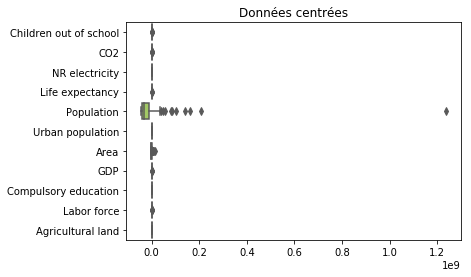

In [4]:
ax=sns.boxplot(data=(filtered_df.drop("Country Name",axis=1) - 
    filtered_df.drop("Country Name",axis=1).mean()),
    orient="h", palette="Set2")
_=ax.set_title(u"Données centrées")

Nous devons également réduire en raison de la variance élevée de la population.

### Réduction 

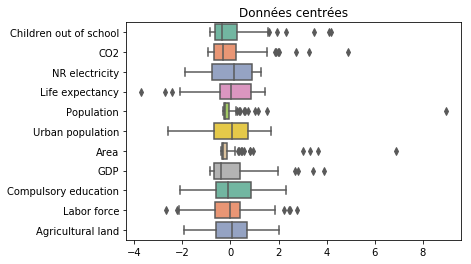

In [5]:
ax=sns.boxplot(data=((filtered_df.drop("Country Name",axis=1) 
    - filtered_df.drop("Country Name",axis=1).mean())
    /filtered_df.drop("Country Name",axis=1).std()), 
    orient="h", palette="Set2")
_=ax.set_title(u"Données centrées")

In [6]:
dfo=(filtered_df.drop("Country Name",axis=1) 
    - filtered_df.drop("Country Name",axis=1).mean()
    )/filtered_df.drop("Country Name",axis=1).std()
dfoc=dfo.copy()
dfoc["Country"]=filtered_df["Country Name"]

# Recherche des outliers

Comme précédemment, nous allons chercher les outliers grâce à DBSCAN. La première étape sera donc de paramétrer ce modèle en traçant la distance pour chaque point à son 4e plus proche voisin grâce à l'algorithme des KNN.

### Définition des paramètres de DBSCAN grâce à KNN

In [7]:
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(dfo)
distances, indices = nbrs.kneighbors(dfo)
distances_to_4 = distances[:,3]
distances_to_4 = sorted(distances_to_4 , reverse = False)

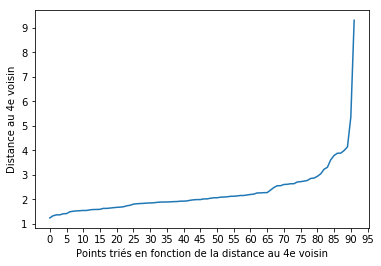

In [107]:
Index = range(0,len(distances_to_4))
plt.plot(Index , distances_to_4)
plt.xlabel(u'Points triés en fonction de la distance au 4e voisin')
t=plt.ylabel(u'Distance au 4e voisin')
_=plt.xticks(np.arange(0, 100, step=5))

On observe un coude pour les pays d'indices entre 75 et 85.

In [9]:
mean_dist_knee = sum(distances_to_4[75:85])/10
mean_dist_knee

3.0023049703042854

On prendra donc un rayon de recherche d'environ 3 pour considérer un cluster.

### Analyse des résultats de DBSCAN

In [10]:
outliers_det = DBSCAN(min_samples=6,eps=mean_dist_knee).fit(dfo)
print "Il y a",sum(outliers_det.labels_ == -1),"outliers."

Il y a 10 outliers.


In [11]:
dfol= dfo.copy(deep=True)
dfol['Labels'] = outliers_det.labels_

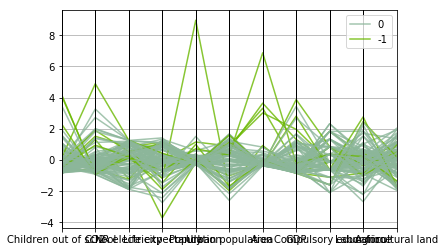

In [12]:
parallel_coordinates(dfol,'Labels', alpha=0.8)
plt.show()

Les outliers sont particulièrement visibles dans le 2e champ (émissions de CO2), le 4e champ (part des énergies non renouvelables) le 5e champ (population) et le 7e champ (PIB).

In [13]:
print(dfoc["Country"][dfol['Labels'] == -1])

10              Australia
26                 Brazil
35                 Canada
47          Cote d'Ivoire
89                  India
116            Luxembourg
149              Pakistan
159                 Qatar
161    Russian Federation
191              Tanzania
Name: Country, dtype: object


Les pays ci-dessus sont les outliers.

In [14]:
dff=dfol[dfol.Labels != -1]
dff=dff.drop('Labels',axis=1)
dff["Country"]=dfoc["Country"][dfol['Labels'] != -1]
dff.head()

,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land,Country
1,0.055405,-0.696201,-1.876930,0.432529,-0.291573,-0.652658,-0.370542,-0.696435,-0.612305,-0.862056,0.131700,Albania
7,-0.764361,-0.275301,0.134525,0.172820,-0.004043,1.213444,0.829788,-0.337704,1.347071,-0.108451,0.671874,Argentina
12,0.169681,-0.380435,1.047264,-0.540938,-0.244274,-0.717287,-0.346060,-0.551382,-0.122461,0.354138,0.825752,Azerbaijan
14,0.158569,2.724599,1.265949,0.236097,-0.303030,1.087830,-0.382340,0.154949,-0.612305,1.132413,-1.421480,Bahrain
17,0.246590,0.077362,1.236223,-0.409758,-0.243917,0.430308,-0.292783,-0.547063,-0.612305,0.282584,0.115869,Belarus


Ce sont les données finales sur lesquelles on va travailler.

# Labels de classe par discrétisation

Nous allons labéliser les données à l'aide d'une étiquette de classe avec le PIB par habitant. On discrétise le PIB par habitant à l'aide d'un Kmeans. 

Pour avoir une idée du nombre de classes, on trace l'histogramme sur les données réduites.

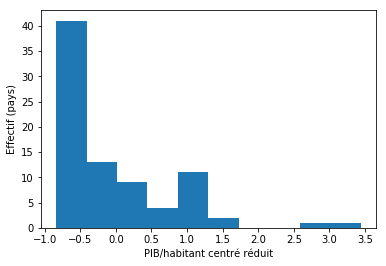

In [15]:
h=plt.hist(dff["GDP"])
plt.xlabel(u"PIB/habitant centré réduit")
plt.ylabel("Effectif (pays)")
_=plt.xticks(np.arange(-1,4,.5))

On distingue 3 classes (<0.5 / 0.5-2.5 / >2.5). 

In [16]:
def kmeans_1D(attribute,n):
    """Prend en entrée un nparray et n clusters"""
    km1 = KMeans(n_clusters=n,random_state=1)
    # on fixe la graine aléatoire
    km1.fit(attribute.reshape(-1,1))
    return km1

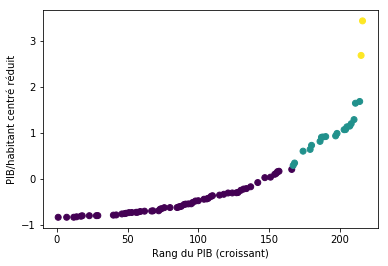

In [17]:
V_GDP  = np.array(sorted(dff['GDP']))
km_gdp = kmeans_1D(V_GDP,3)
plt.scatter(dff.index,sorted(dff['GDP']),c=km_gdp.labels_.astype(np.float))
plt.ylabel(u"PIB/habitant centré réduit")
_=plt.xlabel("Rang du PIB (croissant)")

In [18]:
dff.sort_values(by =['GDP'] , ascending = False).iloc[:2,-1]

147         Norway
188    Switzerland
Name: Country, dtype: object

On observe deux pays très riches par rapport aux autres groupes (la Norvège et la Suisse). On décide d'exclure ces deux pays très riches de l'analyse car l'effectif de cette classe est trop faible. 

In [113]:
unique, counts = np.unique(km_gdp.labels_, return_counts=True)
print counts
print 'Limites de classe pour kmeans :',V_GDP[counts[0]-1]," ; ", V_GDP[counts[0]+counts[1]-1]

[61 19  2]
Limites de classe pour kmeans : 0.20324183820304462  ;  1.6820208216541859


Les limites de classes de kmeans sont proches de celles trouvées graphiquement par l'histogramme.

On compte le nombre de labels de chaque classe.

In [19]:
b=counts[0]-1
a=counts[0]+counts[1]-1

On associe un label à chaque PIB.
On considèrera 2 groupes :
* Les pays pauvres (B)
* Les pays riches (A)

On transforme la colonne correspondante.

In [20]:
def discretize_GDP(counts,df,vect,b,a):
    """Fonction pour discrétiser le PIB dans un dataframe à partir 
    des effectifs de classe de K-means (counts).
    Attention, le PIB doit être en colonne 7.
    Attention, il faut vérifier dans quel ordre sont les clusters 
    dans l'objet counts.
    Retourne un dataframe discrétisé dfd."""
    # Bornes des classes
    dfd=df.copy()
    i=0
    # indexes to drop
    todrop=[]
    for i in range(len(df)):
        # column 7 = GDP
        if df.iloc[i,7]<=vect[b]:
            dfd.iloc[i,7]="B"
        elif df.iloc[i,7]<=vect[a] and dff.iloc[i,7]>vect[b]:
            dfd.iloc[i,7]="A"
        elif dff.iloc[i,7]>vect[a]:
            todrop.append(dfd.index[i])
    for d in todrop:    
        dfd=dfd.drop(index=d)
    return dfd

In [21]:
dfd=discretize_GDP(counts,dff,V_GDP,b,a)
dfd.head()

,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land,Country
1,0.055405,-0.696201,-1.876930,0.432529,-0.291573,-0.652658,-0.370542,B,-0.612305,-0.862056,0.131700,Albania
7,-0.764361,-0.275301,0.134525,0.172820,-0.004043,1.213444,0.829788,B,1.347071,-0.108451,0.671874,Argentina
12,0.169681,-0.380435,1.047264,-0.540938,-0.244274,-0.717287,-0.346060,B,-0.122461,0.354138,0.825752,Azerbaijan
14,0.158569,2.724599,1.265949,0.236097,-0.303030,1.087830,-0.382340,B,-0.612305,1.132413,-1.421480,Bahrain
17,0.246590,0.077362,1.236223,-0.409758,-0.243917,0.430308,-0.292783,B,-0.612305,0.282584,0.115869,Belarus


On a un dafaframe avec le PIB discrétisé.

## Préparation des données pour la classification

In [22]:
dffea = dfd.drop(['GDP','Country'],axis=1)
classes = dfd["GDP"]
sortedLabelList = sorted(list(set(classes)))

## Arbre de décision

### Jeu d'entraiement

In [23]:
prop_tree=.24
tX_train, tX_test, ty_train, ty_test = train_test_split(dffea, classes, test_size=prop_tree, random_state=42)

In [24]:
nleaf=10
treeModel = DecisionTreeClassifier(criterion = 'entropy', random_state=15, min_samples_leaf=nleaf)
t=treeModel.fit(tX_train, ty_train)

In [25]:
tM=metrics.confusion_matrix(y_true=ty_train, y_pred=ty_train, labels=sortedLabelList)
print(tM)

[[15  0]
 [ 0 45]]


Le jeu d'entraînemet compte 15 pays de PIB A et 45 de PIB B.

In [26]:
trueLabels=['A','B']
predictLabels=['a','b']
allLabels=trueLabels+predictLabels

In [114]:
# NE MARCHE PAS CHEZ MOI (pb de path)
dot_data = tree.export_graphviz(t, out_file=None, 
                         feature_names=dffea.columns,  
                         class_names=sortedLabelList, # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

TypeError: Text(17.2,0.5,u'Distance au 4e voisin') is not an estimator instance.

### Jeu test

In [118]:
ty_predict = treeModel.predict(tX_test)
print "Accuracy classique :",metrics.accuracy_score(ty_test, ty_predict)
print u"Accuracy pondérée :",balanced_accuracy_score(ty_test, ty_predict)

Accuracy classique : 1.0
Accuracy pondérée : 1.0


On choisit pour cette étude d'utiliser l'accuracy pondérée car les classes ont des effectifs très différents.

Ici, les deux métriques donnent les mêmes chiffres : mais utiliser l'accuracy pondérée permettrait de ne pas sous-estimer le coût d'une mauvaise classification dans la classe A à cause de son effectif plus faible.

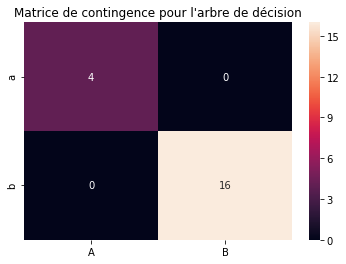

In [29]:
tMP=metrics.confusion_matrix(y_true=ty_test, y_pred=ty_predict, labels=sortedLabelList)
tmdfp = pds.DataFrame(data=tMP, copy=True, index=trueLabels, columns=predictLabels)
tmdfp = tmdfp.transpose()
ax=sns.heatmap(tmdfp, annot=True)
_=ax.set_title(u"Matrice de contingence pour l'arbre de décision")

Matrice de contingence. Verticalement et en minuscule, les classes prédites. Horizontalement et en majuscules, les classes réelles.

In [30]:
print metrics.classification_report(ty_test, ty_predict)

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Ici, tous les scores sont optimaux : la précision est à 1 (aucun faux positif), ainsi que le rappel (aucun faux positif) et le f1-score (c'est la moyenne harmonique des deux).

Il n'y a pas de différence entre les moyennes pondérée et non pondérée ici, mais si c'était le cas, on s'intéresserait plutôt à la moyenne pondérée au vu des différences d'effectif des classes.

## K plus proches voisins

In [169]:
prop_k=.2
kX_train, kX_test, ky_train, ky_test = train_test_split(dffea, classes, test_size=prop_k, random_state=42)
nneighbors=6
knnModel = neighbors.KNeighborsClassifier(n_neighbors=nneighbors, weights='uniform', p=2)
_=knnModel.fit(kX_train, ky_train)

In [163]:
ky_predict = knnModel.predict(kX_test)
print "Accuracy classique :",metrics.accuracy_score(ky_test, ky_predict)
print u"Accuracy pondérée :",balanced_accuracy_score(ky_test, ky_predict)

Accuracy classique : 0.8863636363636364
Accuracy pondérée : 0.8911764705882352


De même que pour l'arbre de décision, il n'y a pas de différences entre les accuracies classique et pondérée. 
Le modèle est excellent.

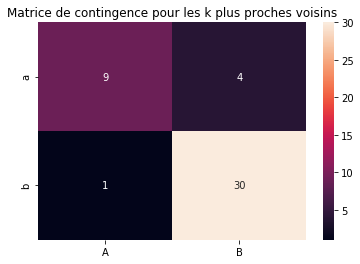

In [164]:
kMP=metrics.confusion_matrix(y_true=ky_test, y_pred=ky_predict, labels=sortedLabelList)
kmdfp = pds.DataFrame(data=kMP, copy=True, index=trueLabels, columns=predictLabels)
kmdfp = kmdfp.transpose()
ax=sns.heatmap(kmdfp, annot=True)
_=ax.set_title(u"Matrice de contingence pour les k plus proches voisins")

Matrice de contingence. Verticalement et en minuscule, les classes prédites. Horizontalement et en majuscules, les classes réelles.

In [165]:
print metrics.classification_report(ky_test, ky_predict)

              precision    recall  f1-score   support

           A       0.69      0.90      0.78        10
           B       0.97      0.88      0.92        34

   micro avg       0.89      0.89      0.89        44
   macro avg       0.83      0.89      0.85        44
weighted avg       0.91      0.89      0.89        44



Ici, le modèle a parfaitement prédit toutes les classes. La précision, le rappel et le f1-score sont maximaux.

## Détection de sur-apprentissage

In [53]:
def plotErrorTest(step,dffeatures,classes,m,start=.01,stop=.99):
    """Trace le pourcentage d'erreur du modèle en fonction de la taille de la classe test.
    step est le pas d'incrémentation de la proportion de classe test.
    dffeatures sont les caractérisiques à prédire.
    classes est la liste des étiquettes de classes à prédire.
    model est le modèle de classificaton (t pour un arbre de décision, k pour les k plus 
    proches voisins).
    start et stop sont les proportions de départ et d'arrivée du jeu test."""
    if m=="k":
        model=neighbors.KNeighborsClassifier(n_neighbors=nneighbors, weights='uniform', p=2)
    prop=np.arange(start,stop,step)
    error=np.ndarray(len(prop))
    i=0
    for p in prop:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            # on fixe la graine aléatoire mais elle est différente à chaque itération
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, 
                classes, test_size=p,random_state=k)
            #train
            # 2 cas en fonction du modèle
            if m=='t':
                #la graine aléatoire est différente à chaque itération
                model = DecisionTreeClassifier(criterion = 'entropy', 
                    random_state=k, min_samples_leaf=nleaf)
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(prop,error)
    plt.xlabel("Proportion du jeu test")
    plt.ylabel(u"Taux d'erreur (%)")
    if m=='k':
        plt.title(u"K plus proches voisins")
    elif m=='t':
        plt.title(u"Arbre de décision")

In [36]:
def plotErrorLeaf(dffeatures,classes,start=1,stop=50):
    """Trace le pourcentage d'erreur du modèle en fonction du nombre minimal 
    d'objets pour faire une feuille.
    dffeatures sont les caractérisiques à prédire.
    classes est la liste des étiquettes de classes à prédire.
    start et stop sont la taille de départ et d'arrivée de la feuille."""
    leaf=np.arange(start,stop)
    error=np.ndarray(len(leaf))
    i=0
    for l in leaf:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            # on fait une moyenne sur plusieurs jeux de test/d'entraînement
            model = DecisionTreeClassifier(criterion = 'entropy', 
                random_state=k, min_samples_leaf=l)
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, 
                classes, test_size=prop_tree,random_state=k)
            #train
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(leaf,error)
    plt.xlabel("Nombre minimal d'objets dans un noeud")
    plt.ylabel(u"Taux d'erreur (%)")
    plt.title(u"Arbre de décision")

In [37]:
def plotErrorNeighbors(dffeatures,classes,start=1,stop=50):
    """Trace le pourcentage d'erreur du modèle en fonction du nombre 
    de voisins utilisé.
    dffeatures sont les caractérisiques à prédire.
    classes est la liste des étiquettes de classes à prédire.
    start et stop sont le nombre de voisins de départ et d'arrivée."""
    neighb=np.arange(start,stop)
    error=np.ndarray(len(neighb))
    i=0
    for n in neighb:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            # On fait une moyenne car l'arbre de décision est aléatoire
            # On change aussi le jeu de test/d'entraînement
            model = neighbors.KNeighborsClassifier(n_neighbors=n, weights='uniform', p=2)
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, 
                classes, test_size=prop_k,random_state=k)
            #train
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(neighb,error)
    plt.xlabel("Nombre de voisins")
    plt.ylabel(u"Taux d'erreur (%)")
    plt.title(u"K plus proches voisins")

### Erreur en fonction de la proportion du jeu test

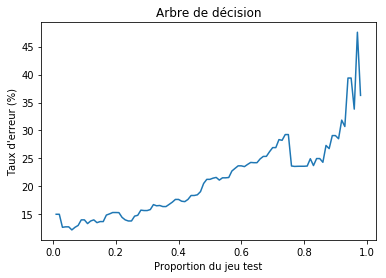

In [38]:
plotErrorTest(.01,dffea,classes,'t')

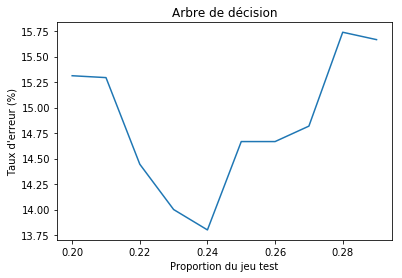

In [39]:
plotErrorTest(.01,dffea,classes,'t',.2,.3)

L'erreur augmente avec la proportion de jeu test. En effet, plus cette proportion est grande et moins le modèle a pu s'entraîner. Cependant, cela n'a aucun sens de choisir un jeu test trop petit (surtout dans notre cas où cela correspondrait à deux ou trois objets).

On choisira une proportion de test de 0,24.

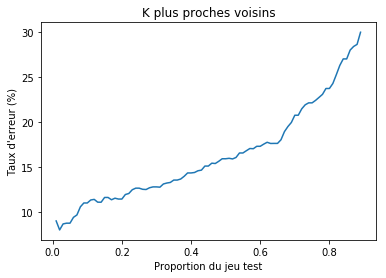

In [40]:
plotErrorTest(.01,dffea,classes,'k',.01,.9)

On choisit une proportion de test de 0,2. 

On remarque que l'erreur associée à l'arbre de décision augmente plus vite que l'erreur associée aux k plus proches voisins.

### Erreur en fonction du nombre minimal d'items pour donner une feuille (arbre de décision)

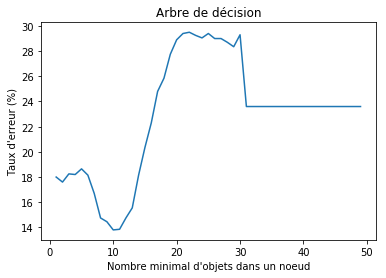

In [41]:
plotErrorLeaf(dffea,classes,1,50)

Le nombre d'objets optimal dans un noeud semble être de 10. En dessous, il y a trop de feuiles et il y a sur-apprentissage. Au dessus, le modèle est trop simple.

### Erreur en fonction du nombre de voisins (knn)

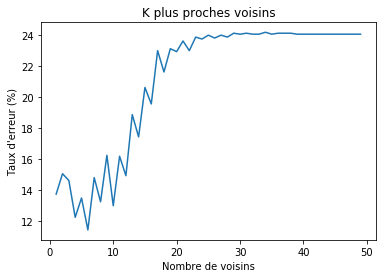

In [42]:
plotErrorNeighbors(dffea,classes,1,50)

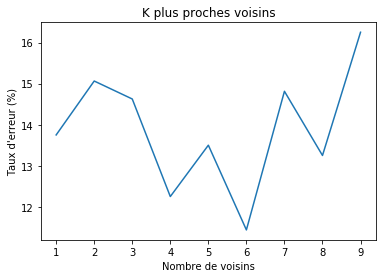

In [43]:
plotErrorNeighbors(dffea,classes,1,10)

Si l'algorithme ne considère pas assez de voisins, les résultats sont mauvais car l'apprentissage est trop spécifique (par exemple, s'il y a du bruit, un point peut-être classifié à tort comme un voisin proche). Si on considère trop de voisins, les classes sont trop générales et donc mal définies.
Le nombre de voisins optimal semble être 6.

## Comparaison des deux méthodes de classification

### Accuracy

Comme l'arbre de décision est une méthode aléatoire et qu'on peut tester plusieurs jeux test/entraînement, on considère un score d'accurracy moyen sur plusieurs runs.


Pour les k plus proches voisins, même si l'algorithme est déterministe, on considère également un score d'accuracy moyen sur plusieurs pour plusieurs jeux de test/entraînement.

In [121]:
def meanAccuracy(ni,m,f,c):
    """Calcule l'accuracy pondérée moyenne sur un nombre d'itérations défini par 
    l'utilisateur ni.
    m est le modèle ('t' pour l'arbre de décision, 'k' pour les k plus proches voisins.)
    f est le tableau de features, c est la liste des classes.'"""
    n=ni
    accuracy=np.ndarray(n)
    dffea=f
    classes=c
    if m=='k':
        model = neighbors.KNeighborsClassifier(n_neighbors=nneighbors, weights='uniform', p=2)

    for i in range(n):
        if m=='t':
            X_train, X_test, y_train, y_test = train_test_split(dffea, classes, test_size=prop_tree, random_state=i)
            model = DecisionTreeClassifier(criterion = 'entropy', random_state=i, min_samples_leaf=nleaf)
            train=model.fit(X_train, y_train)
            y_predict = model.predict(X_test)
        elif m=='k':
            X_train, X_test, y_train, y_test = train_test_split(dffea, classes, test_size=prop_k, random_state=i)
            train=model.fit(X_train, y_train)
            y_predict = model.predict(X_test)
        accuracy[i]=metrics.balanced_accuracy_score(y_test, y_predict)   
    mean=np.mean(accuracy)
    return mean

In [123]:
# Il y a un warning
n=100
meanAccuracyTree=meanAccuracy(n,'t',dffea,classes)
meanAccuracyKnn=meanAccuracy(n,'k',dffea,classes)
print u"Accuracy moyenne pondérée pour l'arbre de décision (",n," runs) :", meanAccuracyTree
print u"Accuracy pondérée des k plus proches voisins (",n," runs) :",meanAccuracyKnn

/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Accuracy moyenne pondérée pour l'arbre de décision ( 100  runs) : 0.8421403560749535
Accuracy pondérée des k plus proches voisins ( 100  runs) : 0.8817367632367633


Les scores d'accuracy sont comparables : mais l'algorithme de l'arbre de décision est légèrement plus performant.

## Précision et rappel

Par simplicité, on considère cette fois des runs uniques.

In [124]:
print "----------------------------- Arbre de décision -----------------------------\n", metrics.classification_report(ty_test, ty_predict)
print "----------------------------- k plus proches voisins -----------------------------\n", metrics.classification_report(ky_test, ky_predict)

----------------------------- Arbre de décision -----------------------------
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

----------------------------- k plus proches voisins -----------------------------
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



Comme on l'a vu ci-dessus, pour nos runs, les modèles sont parfaits. Cependant, il faudrait répéter plusieurs fois et faire une moyenne pour pouvoir interpréter les résultats.

### Entropie

De même, on considère une entropie moyenne sur plusieurs runs. On utilise ici l'entropie normalisée ($\frac{entropie}{log_2(n_{classes}}$)

In [156]:
def meanEntropy(ni,m,f,c):
    """Calcule l'entropie moyenne sur un nombre d'itérations défini par 
    l'utilisateur ni.
    m est le modèle ('t' pour l'arbre de décision, 'k' pour les k plus proches voisins.)
    f est le tableau de features, c est la liste des classes.'"""
    n=ni
    dffea=f
    classes=c
    fentropy=np.ndarray((n,len(set(classes))))
    mean=np.ndarray(2)
    entrop_max=math.log(len(set(classes)),2.)
    print entrop_max
    if m=='k':
        model = neighbors.KNeighborsClassifier(n_neighbors=nneighbors, weights='uniform', p=2)
    for i in range(0,n):
        if m=='t':
            X_train, X_test, y_train, y_test = train_test_split(dffea, classes, test_size=prop_tree, random_state=i)
            model = DecisionTreeClassifier(criterion = 'entropy', random_state=i, min_samples_leaf=nleaf)
            train=model.fit(X_train, y_train)
            y_predict = model.predict(X_test)
        elif m=='k':
            X_train, X_test, y_train, y_test = train_test_split(dffea, classes, test_size=prop_k, random_state=i)
            train=model.fit(X_train, y_train)
            y_predict = model.predict(X_test)
        M=metrics.confusion_matrix(y_true=y_test, y_pred=y_predict, labels=sortedLabelList)
        mdf = pds.DataFrame(data=M, copy=True, index=trueLabels, columns=predictLabels)
        mdf = mdf.transpose()
        if mdf.values.sum(axis=1, keepdims=True)[0]==0 or mdf.values.sum(axis=1, keepdims=True)[1]==0:
            # case divide by zero
            i=i-1
        else:
            proba = mdf.values/mdf.values.sum(axis=1, keepdims=True)
            entrop = np.array([stats.entropy(row, base=2) for row in proba])/entrop_max
            fentropy[i,:]=entrop
    mean=np.sum(fentropy,axis=0)/n 
    return mean

In [153]:
n=100
meanEntropyTree=meanEntropy(n,'t',dffea,classes)
meanEntropyKnn=meanEntropy(n,'k',dffea,classes)
print u"--- Entropie pour l'arbre de décision (",n," runs) --- \n", "A : ", meanEntropyTree[0], " | B : ", meanEntropyTree[1] 
print u"--- Entropie pour les k plus proches voisins (",n," runs) ---\n :",meanEntropyKnn[0], " | B : ", meanEntropyKnn[1] 

1.0
1.0
--- Entropie pour l'arbre de décision ( 100  runs) --- 
A :  0.7306871679167531  | B :  0.29930055395479577
--- Entropie pour les k plus proches voisins ( 100  runs) ---
 : 0.6278111768110831  | B :  0.21740735685729537


L'entropie de la classe A est élevée pour les deux méthodes (autour de 0,7). C'est un mauvais score, puisque l'entropie maximale est 1. 


L'entropie est plus faible pour la classe B, autour de 0,2 pour les deux méthodes. En effet, la classe B étant plus grande, on peut supposer que le modèle apprend mieux : d'autre part, un objet mal classé est donc moins coûteur pour cette classe car elle est plus grande.

L'entropie mesurée pour les deux classes est plus faible pour l'algorithme des k plus proches voisins.


On voit ici l'intérêt de lancer plusieurs fois la simulation : pour les deux algorithmes lancés au début, on obtenait des modèles parfaits alors que c'est loin d'être le cas pour les simulations répétées.

**Conclusion :**

**Accuracy : l'arbre de décision semble plus performant.**

**Entropie : les k plus proches voisins semblent plus performants.**